In [3]:
import sys
sys.path.append("../../dynamic-tokenization")

In [4]:
from tokenizations.dynamic_bpe import Dynamic_BPE
from transformers import AutoTokenizer, AutoModel
import torch
from zett.utils import get_surface_form_matrix
from datasets import load_dataset
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

/home/irantzu/MASTER/WiSe25/Lab Rotation/dynamic-tokenization/dynamic_tokenization_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load Latxa tokenizer
latxa_tokenizer = AutoTokenizer.from_pretrained("HiTZ/latxa-7b-v1.1")

In [6]:
# Load hypernetwork (Meta-LLaMA-3 as closest match)
hypernet = AutoModel.from_pretrained(
    "benjamin/zett-hypernetwork-Meta-Llama-3-8B-experimental",
    trust_remote_code=True
)

hypernet_tokenizer = AutoTokenizer.from_pretrained(
    "benjamin/zett-hypernetwork-Meta-Llama-3-8B-experimental"
)

In [24]:
# Example sentences
examples = [
    {"text": "Etxea handia da."},
    {"text": "Etxeko atea irekita dago."},
]

# Tokenize with Latxa tokenizer
latxa_tokenizer.pad_token = latxa_tokenizer.eos_token
encoding = latxa_tokenizer(
    [ex["text"] for ex in examples],
    add_special_tokens=True,
    return_tensors="pt",
    padding=True
)
initial_tokens = [
    latxa_tokenizer.convert_ids_to_tokens(ids.tolist())
    for ids in encoding.input_ids
]
print("Initial tokens:", initial_tokens)

# Dynamic BPE (start retrofitting subwords)
dynamic_bpe = Dynamic_BPE(tokenizer=hypernet_tokenizer, tokenizer_boundary='pretokens')
dynamic_tokens, _, _, _ = dynamic_bpe.tokenize_batch(
    batch_examples=examples,
    max_nr_merges=10,
    mlm=True
)
print("Dynamic tokens:", dynamic_tokens)

Initial tokens: [['<s>', '▁E', 'tx', 'ea', '▁hand', 'ia', '▁da', '.', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>'], ['<s>', '▁E', 'tx', 'ek', 'o', '▁a', 'te', 'a', '▁i', 'rek', 'ita', '▁d', 'ago', '.']]
Early exit, 8 out of 10
Dynamic tokens: [['<s>', 'ĠEtxea', 'Ġhandia', 'Ġda', '.', '</s>'], ['<s>', 'ĠEtxeko', 'Ġatea', 'Ġirekita', 'Ġdago', '.', '</s>']]


In [30]:
# Dynamic Tokenization with Latxa and EusCrawl dataset

ds_euscrawl = load_dataset("HiTZ/latxa-corpus-v1.1", 'euscrawl-v1.1')
sentences = ds_euscrawl['train']['text'][:5]
examples = [{"text": s} for s in sentences]

# Initial Tokenization with Latxa
latxa_tokenizer.pad_token = latxa_tokenizer.eos_token
enc = latxa_tokenizer(
    sentences,
    add_special_tokens=True,
    padding=True,
    return_tensors="pt"
)
initial_tokens = [
    latxa_tokenizer.convert_ids_to_tokens(ids.tolist())
    for ids in enc.input_ids
]
print("Initial tokens:")
for i, toks in enumerate(initial_tokens):
    print(f"\nSentence {i}:")
    print(toks)

# Dynamic BPE Tokenization with Hypernetwork Tokenizer
dynamic_bpe = Dynamic_BPE(tokenizer=hypernet_tokenizer, tokenizer_boundary='pretokens')
dynamic_tokens, _, _, _ = dynamic_bpe.tokenize_batch(
    batch_examples=examples,
    max_nr_merges=30,
    mlm=True
)
print("\nDynamic tokens:")
for i, toks in enumerate(dynamic_tokens):
    print(f"\nSentence {i}:")
    print(toks)


Initial tokens:

Sentence 0:
['<s>', '▁Z', 'az', 'pi', '▁et', 'a', '▁b', 'eder', 'at', 'zi', '▁ur', 'te', '▁arte', 'ko', '▁z', 'ig', 'or', '▁es', 'ka', 'er', 'ak', '▁h', 'amar', '▁gaz', 'ter', 'ent', 'zat', '<0x0A>', '<0x0A>', 'H', 'ern', 'an', 'iko', '▁gaz', 'teen', '▁aur', 'k', 'ako', '▁«', 'ep', 'a', 'ik', 'eta', '▁polit', 'iko', 'a', '»', '▁sal', 'atu', '▁du', '▁Ele', 'ak', '-', 'ek', ';', '▁lar', 'un', 'b', 'ater', 'ako', '▁manifest', 'az', 'ior', 'a', '▁de', 'itu', '▁du', '<0x0A>', '<0x0A>', 'I', 'ra', 'ilar', 'en', '▁', '1', '8', 't', 'ik', '▁', '2', '8', 'ra', '▁bit', 'arte', 'an', '▁Hern', 'an', 'iko', '▁h', 'amar', '▁gaz', 'te', '▁ep', 'ait', 'uk', 'o', '▁d', 'itu', 'zte', '▁Esp', 'ain', 'ia', 'ko', '▁A', 'uz', 'it', 'eg', 'i', '▁Nazionale', 'an', '.', '▁Z', 'az', 'pi', '▁et', 'a', '▁b', 'eder', 'at', 'zi', '▁ur', 'te', '▁arte', 'ko', '▁esp', 'et', 'xe', '▁z', 'ig', 'or', 'rak', '▁es', 'k', 'atu', '▁d', 'itu', 'zte', '▁ha', 'ient', 'zat', ',', '▁Seg', 'i', '▁gaz', 'te', '▁er'

Dynamic Tokenization for EusCrawl dataset

In [50]:
# Dynamic Tokenization with Latxa and EusCrawl dataset

ds = load_dataset("HiTZ/latxa-corpus-v1.1", 'euscrawl-v1.1')
sentences = ds['train']['text'][:50000]

BATCH_SIZE = 500

dynamic_bpe = Dynamic_BPE(
    tokenizer=hypernet_tokenizer,
    tokenizer_boundary='pretokens'
)

all_initial_tokens = []
all_dynamic_tokens = []

latxa_tokenizer.pad_token = latxa_tokenizer.eos_token

for i in range(0, len(sentences), BATCH_SIZE):
    batch = sentences[i : i + BATCH_SIZE]
    print(f"Processing batch {i//BATCH_SIZE + 1}...")

    # ❌ DO NOT use padding here
    # Latxa initial tokenization (correct way)
    initial_batch_tokens = [
        latxa_tokenizer.encode(sent, add_special_tokens=True)
        for sent in batch
    ]
    # convert IDs to tokens
    initial_batch_tokens = [
        latxa_tokenizer.convert_ids_to_tokens(ids)
        for ids in initial_batch_tokens
    ]
    all_initial_tokens.extend(initial_batch_tokens)

    # Dynamic BPE tokenization
    examples = [{"text": s} for s in batch]
    dyn_tokens, _, _, _ = dynamic_bpe.tokenize_batch(
        batch_examples=examples,
        max_nr_merges=30,
        mlm=True
    )
    all_dynamic_tokens.extend(dyn_tokens)
print("Tokenization completed.")
print(f"Total sentences processed: {len(all_dynamic_tokens)}")

Processing batch 1...
Processing batch 2...
Processing batch 3...
Processing batch 4...
Processing batch 5...
Processing batch 6...
Processing batch 7...
Processing batch 8...
Processing batch 9...
Processing batch 10...
Processing batch 11...
Processing batch 12...
Processing batch 13...
Processing batch 14...
Processing batch 15...
Processing batch 16...
Processing batch 17...
Processing batch 18...
Processing batch 19...
Processing batch 20...
Processing batch 21...
Processing batch 22...
Processing batch 23...
Processing batch 24...
Processing batch 25...
Processing batch 26...
Processing batch 27...
Processing batch 28...
Processing batch 29...
Processing batch 30...
Processing batch 31...
Processing batch 32...
Processing batch 33...
Processing batch 34...
Processing batch 35...
Processing batch 36...
Processing batch 37...
Processing batch 38...
Processing batch 39...
Processing batch 40...
Processing batch 41...
Processing batch 42...
Processing batch 43...
Processing batch 44.

In [9]:
def flatten(list_of_lists):
    for sub in list_of_lists:
        for item in sub:
            yield item

1. Average tokens per word

In [21]:
def average_tokens_per_word(sentences, token_lists):
    total_words = 0
    total_tokens = 0

    for sent, toks in zip(sentences, token_lists):
        words = sent.split()
        total_words += len(words)
        total_tokens += len(toks)

    return total_tokens / total_words

avg_tokens_initial = average_tokens_per_word(sentences, all_initial_tokens)
avg_tokens_dynamic = average_tokens_per_word(sentences, all_dynamic_tokens)
print(f"Initial average tokens per word: {avg_tokens_initial:.2f}")
print(f"Dynamic average tokens per word: {avg_tokens_dynamic:.2f}")

Initial average tokens per word: 3.20
Dynamic average tokens per word: 2.42


2. Token length distribution

In [27]:
def token_length_distribution(token_lists):
    token_lengths = [len(tok) for tok in flatten(token_lists)]
    return Counter(token_lengths)

dist_latxa = token_length_distribution(all_initial_tokens)
dist_dyn = token_length_distribution(all_dynamic_tokens)
print(dist_latxa)
print(dist_dyn)

Counter({2: 11098881, 3: 9868105, 1: 6175265, 4: 3761995, 6: 834962, 5: 687524, 7: 76985, 8: 35332, 9: 23484, 10: 9532, 11: 5370, 12: 1959, 13: 1125, 16: 323, 14: 106, 15: 2})
Counter({3: 7178028, 2: 6844762, 4: 4315165, 1: 4109719, 5: 1480875, 6: 450792, 7: 146431, 8: 84487, 9: 32157, 10: 10417, 11: 6928, 12: 3524, 13: 163, 14: 111, 16: 47, 32: 41, 24: 28, 20: 11, 64: 6, 48: 6, 15: 6, 30: 5, 33: 3, 96: 3, 80: 1, 72: 1, 70: 1, 17: 1})


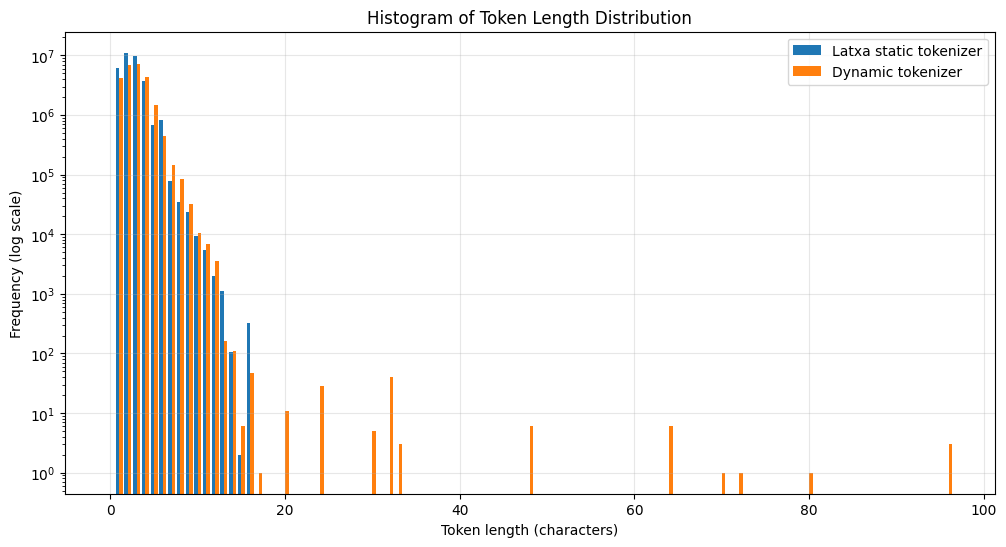

In [29]:
# Prepare bins — cover all possible lengths
max_len = max(max(dist_latxa.keys()), max(dist_dyn.keys()))
bins = np.arange(0, max_len + 2)  # +2 so last value is included

# Convert counters to arrays matching bins
latxa_freq = np.zeros_like(bins[:-1])
dyn_freq   = np.zeros_like(bins[:-1])

for length, count in dist_latxa.items():
    latxa_freq[length] = count

for length, count in dist_dyn.items():
    dyn_freq[length] = count

plt.figure(figsize=(12, 6))

# Plot side-by-side bars
width = 0.4
plt.bar(bins[:-1] - width/2, latxa_freq, width=width, label="Latxa static tokenizer")
plt.bar(bins[:-1] + width/2, dyn_freq,   width=width, label="Dynamic tokenizer")

plt.yscale("log")
plt.xlabel("Token length (characters)")
plt.ylabel("Frequency (log scale)")
plt.title("Histogram of Token Length Distribution")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


3. Word coverage

In [53]:
def word_coverage_dynamic(sentences, all_dynamic_tokens):
    total = 0
    single = 0
    total_sent = 0
    words = []
    for sent in sentences:
        words = sent.split()
        total += len(words)
        total_sent += 1
        # Get corresponding dynamic tokens
        dyn_toks = all_dynamic_tokens[total_sent - 1]
        # Reconstruct words from dynamic tokens
        reconstructed_words = []
        current_word = ""
        for tok in dyn_toks:
            if tok.startswith("Ġ"):  # assuming Ġ indicates a new word
                if current_word:
                    reconstructed_words.append(current_word)
                current_word = tok[1:]  # remove Ġ
            else:
                current_word += tok
        if current_word:
            reconstructed_words.append(current_word)
        # Check coverage
        for word in words:
            if word in reconstructed_words:
                single += 1
    return {"total": total, "single": single}
    

coverage_dynamic = word_coverage_dynamic(sentences[:10000], all_dynamic_tokens[:10000])
print(f"Initial tokenizer coverage: 7.59%")
print(f"Dynamic tokenizer coverage: {(coverage_dynamic['single']/coverage_dynamic['total'])*100:.2f}%")


Initial tokenizer coverage: 7.59%
Dynamic tokenizer coverage: 83.85%


4. Most common subwords

In [54]:
def most_common_subwords(token_lists, n=50):
    return Counter(flatten(token_lists)).most_common(n)

common_initial = most_common_subwords(all_initial_tokens, n=15)
common_dynamic = most_common_subwords(all_dynamic_tokens, n=15)

print("Most common subwords in initial tokenizer:")
for subword, count in common_initial:
    print(f"{subword}: {count}")
print("\nMost common subwords in dynamic tokenizer:")
for subword, count in common_dynamic:
    print(f"{subword}: {count}")

Most common subwords in initial tokenizer:
a: 925826
,: 897237
.: 685129
an: 678140
<0x0A>: 622992
ak: 532591
▁et: 441600
ko: 440448
en: 390349
▁b: 322206
▁d: 320535
u: 312059
k: 301472
z: 287452
o: 287225

Most common subwords in dynamic tokenizer:
,: 764084
.: 579441
Ċ: 542582
ak: 540520
Ġeta: 353761
an: 352750
a: 253279
z: 243265
u: 228259
ako: 224858
Ġ: 212373
ko: 205558
aren: 184735
ik: 168161
en: 161462


5. Special token usage

In [56]:
# Special tokens (e.g., padding, unknown, BOS, EOS)
print("Special tokens:", latxa_tokenizer.special_tokens_map)
print("Special tokens:", hypernet_tokenizer.special_tokens_map)

Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}
Special tokens: {'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>', 'pad_token': '<|end_of_text|>'}


6. Tokenization consistency

In [57]:
families = {
    "etxe (house)": ["etxe", "etxea", "etxeak", "etxeko", "etxeetako", "etxearen",
                    "etxeen", "etxean","etxeetan", "etxetik", "etxeetatik", "etxera",
                    "etxeetara", "etxerantz", "etxeetarantz"],
    "eskola (school)": ["eskola", "eskolak", "eskolako", "eskoletako", "eskolaren",
                       "eskolen", "eskolan", "eskoletan", "eskolatik", "eskoletatik",
                       "eskolara", "eskoletara", "eskolarantz", "eskoletarantz"],
    "neska (girl)": ["neska", "neskak", "neskek", "neskaren", "nesken", "neskari",
                     "neskei", "neskarekin", "neskekin", "neskarengana", "neskengana"],
    "ume (kid)": ["ume", "umea", "umeak", "umeek", "umearen", "umeen", "umeari", 
                  "umeei", "umearekin", "umeekin", "umearengana", "umeengana"],
    "osasun (health)": ["osasun-zerbitzu", "osasun-sistema", 
                        "osasun-politika", "osasun-langile", "osasun-zentro", 
                        "osasun-etxe", "osasun-krisi", "osasun-arazo"]
}

In [58]:
def analyze_family(words):
    print("\n=== Morphological Family ===")
    for w in words:
        tokens = hypernet_tokenizer.tokenize(w)
        print(f"{w:<15} → {tokens}")

for family, words in families.items():
    print(f"\n############################")
    print(f"### {family}")
    print("############################")
    analyze_family(words)


############################
### etxe (house)
############################

=== Morphological Family ===
etxe            → ['Ġet', 'xe']
etxea           → ['Ġet', 'xea']
etxeak          → ['Ġet', 'xe', 'ak']
etxeko          → ['Ġet', 'x', 'eko']
etxeetako       → ['Ġet', 'xe', 'et', 'ako']
etxearen        → ['Ġet', 'xe', 'aren']
etxeen          → ['Ġet', 'xe', 'en']
etxean          → ['Ġet', 'x', 'ean']
etxeetan        → ['Ġet', 'xe', 'et', 'an']
etxetik         → ['Ġet', 'x', 'etik']
etxeetatik      → ['Ġet', 'xe', 'etat', 'ik']
etxera          → ['Ġet', 'x', 'era']
etxeetara       → ['Ġet', 'xe', 'et', 'ara']
etxerantz       → ['Ġet', 'x', 'er', 'antz']
etxeetarantz    → ['Ġet', 'xe', 'et', 'ar', 'antz']

############################
### eskola (school)
############################

=== Morphological Family ===
eskola          → ['Ġesk', 'ola']
eskolak         → ['Ġesk', 'ol', 'ak']
eskolako        → ['Ġesk', 'ol', 'ako']
eskoletako      → ['Ġes', 'ko', 'let', 'ako']
eskolaren      